# Алгоритмы кластеризации

Основная задача этого задания - реализация одного из алгоритмов кластеризации.
Кроме того, необходимо будет проверить корректность работы алгоритма на тестовых данных, проверить работу алгоритма на данных различной природы, подбирать параметры алгоритма.

In [1]:
import random
import pandas as pd
import pylab as pl
import numpy as np
import scipy.spatial as ss
import sklearn.cluster as sc
import sklearn.manifold as sm
import sklearn.datasets as ds
import sklearn.metrics as smt

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import cluster, datasets, mixture
from itertools import cycle, islice

%matplotlib inline

plt.rcParams['figure.figsize'] = (12, 8)


## Реализация алгоритма

Необходимо выбрать и реализовать самостоятельно один из следующих алгоритмов кластеризации:
* Агломеративная иерархическая кластеризация с поддержкой single-linkage, complete-linkage, average-linkage (параметры - k, linkage)
* DBSCAN. (параметры - epsilon, min_pts) - нужно самостоятельно разобрать и применить критерий качества для DBSCAN
* OPTICS(\*). (параметры - epsilon, min_pts)
* Gaussian Mixture Model(\*\*) с использованием maximum a-posteriori для выбора кластера (параметр - k)

(\*) - алгоритм не был разобран на занятии. Выбирайте этот пункт только если уверенно умеете программировать и хотите разобраться с более сложной идеей, чем DBSCAN  
(\*\*) - алгоритм не был разобран на занятии, задание повышенной сложности. Выбирайте этот пункт только если хотите разобраться со сложным математическим обоснованием и точно уверены, что сможете запрограммировать и отладить.

## Интерфейс
Алгоритм кластеризации должен удовлетворять следующему интерфейсу. Конструктор принимает набор параметров, необходимых для работы алгоритма кластеризации. Метод `fit` подсчитывает параметры модели и возвращает `self`. Метод `predict` возвращает вектор с индексами кластеров для поданных в него объектов `x`

In [10]:
from scipy.spatial import distance
a = (1, 2, 3)
b = (4, 5, 6)
dst = distance.euclidean(a, a)

In [14]:
a

array([[7.85528719e-01, 9.82487247e-04],
       [9.29733391e-01, 9.51609347e-01],
       [9.36131780e-01, 5.48736214e-01],
       [1.77133883e-01, 7.52346081e-02],
       [6.22253788e-01, 5.33399832e-01],
       [4.72274754e-01, 1.02322299e-01],
       [8.74587108e-01, 7.27828769e-01],
       [8.74429899e-01, 3.90177195e-01],
       [6.16340567e-01, 4.79422153e-01],
       [9.83198669e-01, 3.89982073e-01]])

In [42]:
import scipy.spatial
a = np.random.random((10,2))
qq = scipy.spatial.distance.cdist(a,a)
qq

array([[0.        , 0.96150217, 0.56808048, 0.61290917, 0.55689041,
        0.32923822, 0.73228199, 0.39921916, 0.50747329, 0.43634171],
       [0.96150217, 0.        , 0.40292394, 1.15517908, 0.5190789 ,
        0.96465377, 0.23047529, 0.56414939, 0.56672375, 0.5641664 ],
       [0.56808048, 0.40292394, 0.        , 0.89458458, 0.31425244,
        0.64377692, 0.18937236, 0.17014137, 0.32721684, 0.16558433],
       [0.61290917, 1.15517908, 0.89458458, 0.        , 0.63878565,
        0.2963813 , 0.95515451, 0.76512128, 0.59688364, 0.86533601],
       [0.55689041, 0.5190789 , 0.31425244, 0.63878565, 0.        ,
        0.45642256, 0.31855096, 0.29000951, 0.05430061, 0.38839395],
       [0.32923822, 0.96465377, 0.64377692, 0.2963813 , 0.45642256,
        0.        , 0.74371606, 0.4945596 , 0.40368213, 0.58633727],
       [0.73228199, 0.23047529, 0.18937236, 0.95515451, 0.31855096,
        0.74371606, 0.        , 0.33765161, 0.35832544, 0.35487584],
       [0.39921916, 0.56414939, 0.1701413

In [43]:
np.linalg.norm(a - a[:,None], axis=-1)

array([[0.        , 0.96150217, 0.56808048, 0.61290917, 0.55689041,
        0.32923822, 0.73228199, 0.39921916, 0.50747329, 0.43634171],
       [0.96150217, 0.        , 0.40292394, 1.15517908, 0.5190789 ,
        0.96465377, 0.23047529, 0.56414939, 0.56672375, 0.5641664 ],
       [0.56808048, 0.40292394, 0.        , 0.89458458, 0.31425244,
        0.64377692, 0.18937236, 0.17014137, 0.32721684, 0.16558433],
       [0.61290917, 1.15517908, 0.89458458, 0.        , 0.63878565,
        0.2963813 , 0.95515451, 0.76512128, 0.59688364, 0.86533601],
       [0.55689041, 0.5190789 , 0.31425244, 0.63878565, 0.        ,
        0.45642256, 0.31855096, 0.29000951, 0.05430061, 0.38839395],
       [0.32923822, 0.96465377, 0.64377692, 0.2963813 , 0.45642256,
        0.        , 0.74371606, 0.4945596 , 0.40368213, 0.58633727],
       [0.73228199, 0.23047529, 0.18937236, 0.95515451, 0.31855096,
        0.74371606, 0.        , 0.33765161, 0.35832544, 0.35487584],
       [0.39921916, 0.56414939, 0.1701413

In [22]:
t = qq[1]
t

array([0.38560503, 0.        , 0.40848471, 0.29492278, 0.58336593,
       0.69751372, 0.02124278, 0.24568619, 0.74396693, 0.40464491])

In [23]:
np.where(t>0.38)

(array([0, 2, 4, 5, 8, 9]),)

In [139]:
from sklearn.base import BaseEstimator, ClusterMixin

class Clustering(BaseEstimator, ClusterMixin):
    """
    Implement clustering algorithm according DBSCAN
    """
    
    def __init__(self, eps, min_pts):
        """
        Please add necessary algoritm parameters to class constructor.
        """
        self.eps = eps
        self.min_pts = min_pts
        return
    
    def _compute_distances(self):
        # Посчитаем расстояние от каждой точки до каждой
        import scipy.spatial
        self.Dist = scipy.spatial.distance.cdist(self.X, self.X)
        
    def fit(self, x, y=None):
        """
        Use data matrix x to compute model parameters
        """
        self.x_len = len(x)
        self.X = x
        self._compute_distances()
        # Инициализируем метки для точек. 0 - для непосещенных
        self.labels_ = [0] * self.x_len
        
        # Инициализируем label кластера как 0
        C = 0
        
        for p in range(0, self.x_len):
            #Пропускаем если точка была уже рассмотрена
            if self.labels_[p] != 0:
                continue
            #Находим всех соседей в окрестности
            neighbors = self._regionQuery(p)
            
            # Помечаем шум как "-1"
            if len(neighbors) < self.min_pts:
                self.labels_[p] = -1
            else:
                C += 1
                self._expandCluster(neighbors, p, C)                            
        
        return self
    
#     def _regionQuery(self, p):
#         "Ищем всех соседей в окрестности"
#         neighbors = []
#         for pn in range(0, self.x_len):
#             if np.linalg.norm(self.X[p] - self.X[pn]) < self.eps:
#                 neighbors.append(pn)
#         return neighbors

    def _regionQuery(self, p):
        neighbors = np.where((self.Dist[p] < self.eps))
        return list(list(neighbors)[0])
        

    
    def _expandCluster(self, neighbors, p, C):
        # Назначаем точку кластеру C
        self.labels_[p] = C
        
        i = 0
        while i < len(neighbors):
            Pn = neighbors[i]
            if self.labels_[Pn] == -1:
                self.labels_[Pn] = C
            elif self.labels_[Pn] == 0:
                self.labels_[Pn] = C
                PnNeighbors = self._regionQuery(Pn)
            
                
                if len(PnNeighbors) >= self.min_pts:
                    neighbors += PnNeighbors
            i += 1
        
    def predict(self, x):
        """
        Using computed model parameters predict cluster
        for all objects from x
        """
        #return [random.randint(0,5) for r in range(self.x_len)]
        return self.labels_
    
    def fit_predict(self, x, y=None):
        self.fit(x, y)
        return self.predict(x)

Сначала проверим реализованный алгоритм кластеризации на классическом наборе данных [Iris](http://www.wikiwand.com/en/Iris_flower_data_set). Загрузим данные (они включены в библиотеку sklearn) и посмотрим на то, как они выглядят в двух проекциях (для простоты используем 2 класса из 3).

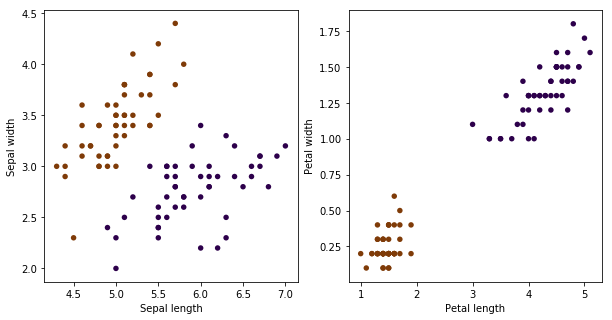

In [145]:
iris = ds.load_iris()
x_iris = iris.data[:100]
y_iris = iris.target[:100]

pl.figure(figsize=(10, 5))

pl.subplot(1, 2, 1)
pl.scatter(x_iris[:, 0], x_iris[:, 1], c=y_iris, cmap=pl.cm.PuOr, lw=0, s=30)
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')

pl.subplot(1, 2, 2)
pl.scatter(x_iris[:, 2], x_iris[:, 3], c=y_iris, cmap=pl.cm.PuOr, lw=0, s=30)
plt.xlabel('Petal length')
plt.ylabel('Petal width')
pl.show()

Видно, что классы разделяются, поэтому можно надеяться, что наш алгоритм "найдет" кластеры, соответствующие исходным классам. Результат работы реализованного алгоритма кластеризации предлагается сравнить с эталонной кластеризацией. Для этого предлагается изучить метрику ([adjusted rand score](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.adjusted_rand_score.html)). В случае если значение этой метрики сильно отличается от 1, предлагается поработать над улучшением реализации своего алгоритма. 

In [141]:
pred_iris = Clustering(eps = 0.55, min_pts = 3).fit_predict(x_iris)
print("Adjusted Rand index for iris is: %.2f" % smt.adjusted_rand_score(y_iris, pred_iris))

Adjusted Rand index for iris is: 0.91


In [142]:
pred_iris = cluster.DBSCAN(eps = 0.55, min_samples = 3).fit_predict(x_iris)
print("Adjusted Rand index for iris is: %.2f" % smt.adjusted_rand_score(y_iris, pred_iris))

Adjusted Rand index for iris is: 0.91


Подобрать параметры модели с использованием эвристик и критериев качества. 

Критерий локтя:
- Инерция (сумма квадратов расстояний от каждой из точек до ближайшего к этой точке центроида)
- Средний диаметр (максимальное расстояние между точками в кластере) или радиус (расстояние от центроида до самой дальней от него точки в кластере)
- Sihouette

Для DBSCAN применяется эвристика по подсчету среднего расстояния до min-pts точек, их сортировки, далее применяется критерий локтя (описание https://habrahabr.ru/post/322034/ или http://www.aaai.org/Papers/KDD/1996/KDD96-037.pdf)

Применим критерий для выбора параметров алгоритма. Предлагается изменить следующий код таким образом, чтобы кластеризация вызывалась с верным набором параметров, а так же при необходимости изменить этот код (для DBSCAN). На графике можно будет увидеть зависимость критерия от параметров алгоритма. Необходимо выбрать оптимальные значения этих параметров. Возможно, необходимо построить такую визуализацию несколько раз.

**Выбор оптимального eps для dbscan с помощью метода k-nearest**

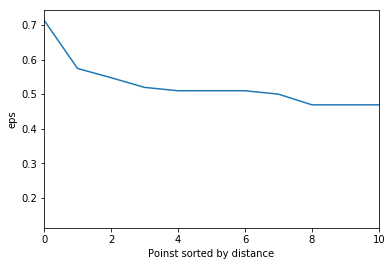

In [143]:
from sklearn.neighbors import NearestNeighbors
ns = 3
nbrs = NearestNeighbors(n_neighbors=ns).fit(x_iris)
distances, indices = nbrs.kneighbors(x_iris)
distanceDec = sorted(distances[:,ns-1], reverse=True)
plt.plot(indices[:,0], distanceDec)
plt.xlim(0,10);
plt.xlabel('Poinst sorted by distance');
plt.ylabel('eps');

**Оптимальное значение  eps = 0.55 при min_pts = 3**

Далее необходимо кластеризовать с помощью реализованного алгоритма данные, используемые для демонстраций на предыдущих занятиях. Предлагается сделать сравнение с реализацией из sklearn.

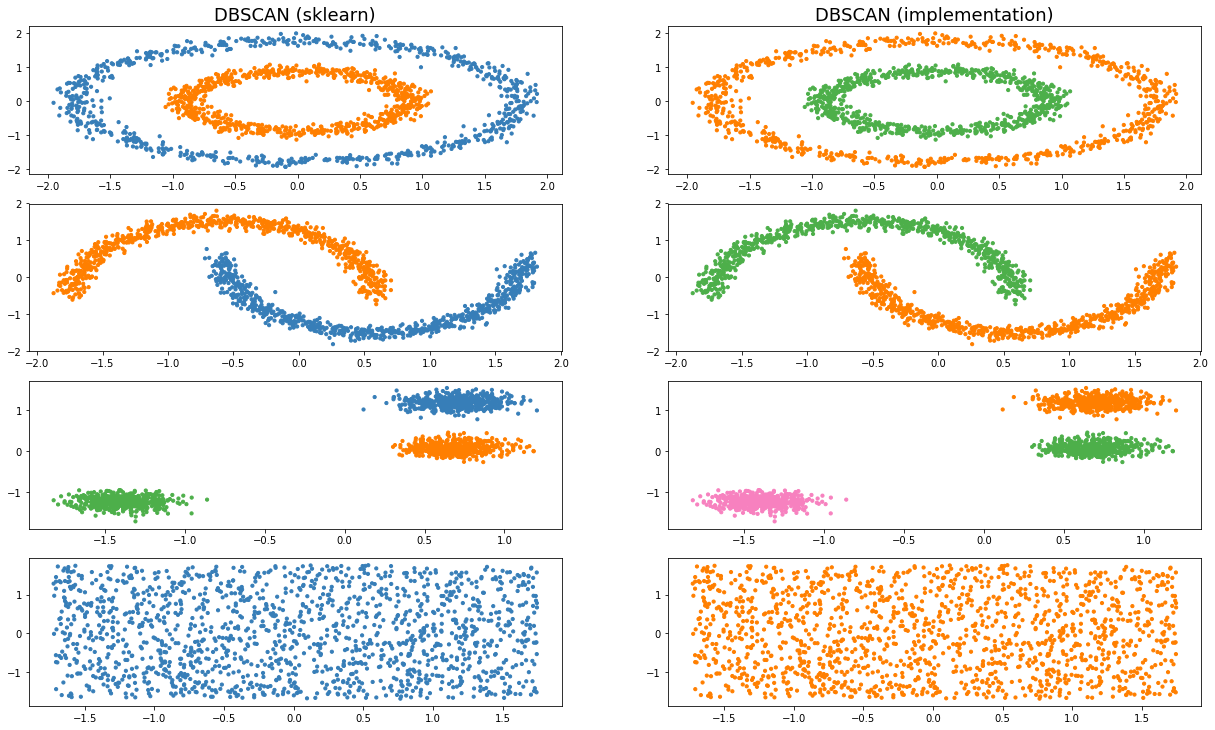

In [144]:
from sklearn import cluster, datasets, mixture

# http://scikit-learn.org/stable/auto_examples/cluster/plot_cluster_comparison.html
%matplotlib inline


import numpy as np
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.preprocessing import StandardScaler

np.random.seed(0)

n_samples = 1500
noisy_circles = datasets.make_circles(n_samples=n_samples, factor=.5,
                                      noise=.05)
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=.05)
blobs = datasets.make_blobs(n_samples=n_samples, random_state=8)
no_structure = np.random.rand(n_samples, 2), None


plt.figure(figsize=(9 * 2 + 3, 12.5))
plot_num = 1



data = [noisy_circles, noisy_moons, blobs, no_structure]
for i_dataset, dataset in enumerate(data):
    X, y = dataset
    # normalize dataset for easier parameter selection
    X = StandardScaler().fit_transform(X)
    
    clustering_algorithms = (\
        ('DBSCAN (sklearn)', cluster.DBSCAN(eps = 0.3, min_samples = 5)),
        ('DBSCAN (implementation)', Clustering(eps = 0.3, min_pts = 5))
        )
    
    for name, algorithm in clustering_algorithms:
        y_pred = algorithm.fit(X).labels_               
        plt.subplot(len(data), len(clustering_algorithms), plot_num)        
        if i_dataset == 0:
            plt.title(name, size=18)
        colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a',
                                             '#f781bf', '#a65628', '#984ea3',
                                             '#999999', '#e41a1c', '#dede00']),
                                  int(max(y_pred) + 1))))
        plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[y_pred])
        plot_num +=1

plt.show()

## Дополнительное задание (не является обязательным)


Примените три любых алгоритма кластеризации из библиотеки sklearn на выбранном вами датасете (реальные данные, датасет с kaggle и пр.). Желательно выбрать легко интерпретируемые данные - например, данные о товарах или пользователях, где есть название, пол, возраст, а так же любые другие легко воспринимаемые признаки.

После применения алгоритма покажите в каждом кластере несколько представителей и проинтерпретируйте результат.

In [ ]:
# https://www.kaggle.com/vjchoudhary7/customer-segmentation-tutorial-in-python

In [146]:
dataset = pd.read_csv('data/Mall_Customers.csv')
print(dataset.shape)
dataset.head()

(200, 5)


,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [147]:
# Для целей анализа были выбраны два признака: Annual Income и Spending Score
X = dataset.iloc[:, [3,4]].values
X = StandardScaler().fit_transform(X)

/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


### 1. Kmeans

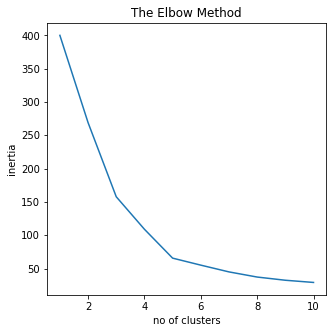

In [148]:
from sklearn.cluster import KMeans
inertia=[]
for i in range(1,11):
    kmeans = KMeans(n_clusters= i, init='k-means++', random_state=0)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)

plt.figure(figsize = (5,5))
plt.plot(range(1,11), inertia)
plt.title('The Elbow Method')
plt.xlabel('no of clusters')
plt.ylabel('inertia')
plt.show()

In [153]:
# k = 5
kmeansmodel = KMeans(n_clusters= 5, init='k-means++', random_state=0)
y_pred= kmeansmodel.fit_predict(X)


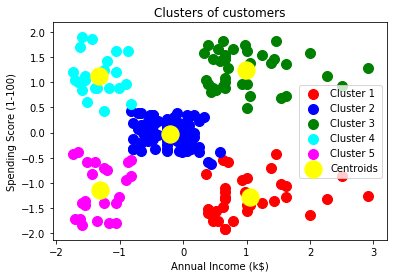

In [154]:
#Visualizing all the clusters 

plt.scatter(X[y_pred == 0, 0], X[y_pred == 0, 1], s = 100, c = 'red', label = 'Cluster 1')
plt.scatter(X[y_pred == 1, 0], X[y_pred == 1, 1], s = 100, c = 'blue', label = 'Cluster 2')
plt.scatter(X[y_pred == 2, 0], X[y_pred == 2, 1], s = 100, c = 'green', label = 'Cluster 3')
plt.scatter(X[y_pred == 3, 0], X[y_pred == 3, 1], s = 100, c = 'cyan', label = 'Cluster 4')
plt.scatter(X[y_pred == 4, 0], X[y_pred == 4, 1], s = 100, c = 'magenta', label = 'Cluster 5')
plt.scatter(kmeansmodel.cluster_centers_[:, 0], kmeansmodel.cluster_centers_[:, 1], s = 300, c = 'yellow', label = 'Centroids')
plt.title('Clusters of customers')
plt.xlabel('Annual Income (k$)')
plt.ylabel('Spending Score (1-100)')
plt.legend()
plt.show()

Возможная интерпретация кластеров:1) Красный - зарабатывают много, но тратят мало <br>2) Зеленый - зарабатывают много и тратят много <br>3) Бирюзовый - зарабатывают мало, но тратят много <br>4) Фиолетовый - зарабатывают мало и тратят мало <br>5) Синии - средний кластер



In [175]:
# dbscan = cluster.DBSCAN(eps = 0.4, min_samples=5)
# y_pred = dbscan.fit(X).labels_

# n_clusters = len(np.unique(y_pred))
# colors = sns.color_palette("Set1", n_clusters)
# plt.figure(figsize= (5,5))
# for cluster_ in np.unique(y_pred):
#     color = colors.pop()
#     plt.scatter(X[y_pred == cluster_, 0], X[y_pred == cluster_, 1], c = color, label = 'Cluster ' + str(cluster_))
#     plt.legend()
   